In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [3]:
data=pd.read_csv('/content/gdrive/MyDrive/sentiment/newData.csv') #new data contains only joy sad fear

In [4]:
data.head()

,Unnamed: 0,text,emotions
0,0,i feel awful about it too because it s my job ...,sadness
1,1,im alone i feel awful,sadness
2,3,i was feeling a little low few days back,sadness
3,11,i also feel disillusioned that someone who cla...,sadness
4,16,i wish you knew every word i write i write for...,sadness


# Preprocessing Starts Here

In [5]:
data=data[['text','emotions']]#faltu ki chiz removed

In [6]:
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,i was feeling a little low few days back,sadness
3,i also feel disillusioned that someone who cla...,sadness
4,i wish you knew every word i write i write for...,sadness


In [7]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


In [8]:
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,i was feeling a little low few days back,sadness
3,i also feel disillusioned that someone who cla...,sadness
4,i wish you knew every word i write i write for...,sadness


In [9]:
print(data[data['emotions']=='sadness'].shape)
print(data[data['emotions']=='joy'].shape)
# print(data[data['emotions']=='love'].size)
# print(data[data['emotions']=='anger'].size)
print(data[data['emotions']=='fear'].shape)

# isse graph bnado

(121187, 2)
(141067, 2)
(47712, 2)


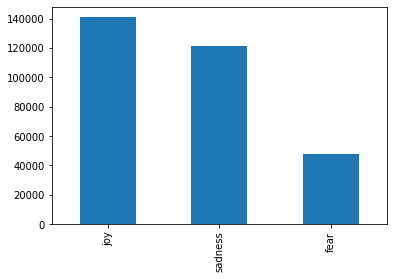

In [10]:
data.emotions.value_counts().plot.bar()

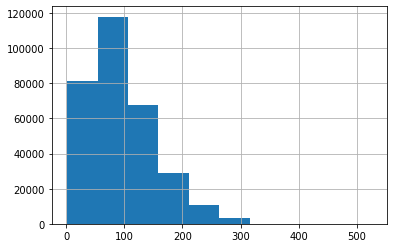

count    309966.000000
mean         96.233003
std          55.920283
min           2.000000
25%          53.000000
50%          85.000000
75%         127.000000
max         525.000000
dtype: float64

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len=[len(x) for x in data['text']]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [12]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')

tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
print(X.shape)

(309966, 90)


# Model Building starts here

In [13]:
embed_dim = 16
lstm_out = 16

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])#use categorical_crossentropy..no it is correct This is a multi-labels classification task, not multi-classes classification: in former case each label corresponds to a binary classification problem, one comment could have multiple labels; in latter case one comment can only be assign as one labels. And you can see in many kernels they use sigmoid activation rather than softmax.These classes are not mutually exclusive. The sum of probabilities each row can be larger than 1 as you can see in the training set.
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 16)            32000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 34,163
Trainable params: 34,163
Non-trainable params: 0
_________________________________________________________________
None


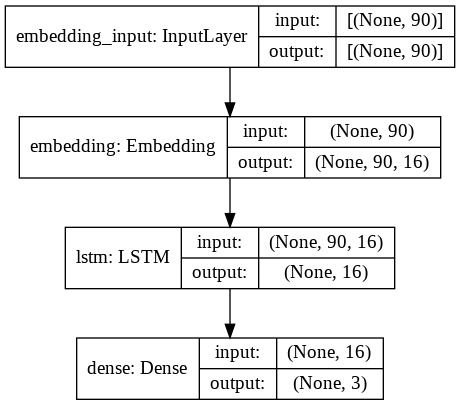

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
Y = pd.get_dummies(data['emotions']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(207677, 90) (207677, 3)
(102289, 90) (102289, 3)


In [ ]:
# batch_size = 32
# model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Epoch 1/3
6490/6490 [==============================] - 1913s 295ms/step - loss: 0.1222 - accuracy: 0.9314
Epoch 2/3
6490/6490 [==============================] - 1878s 289ms/step - loss: 0.0355 - accuracy: 0.9784
Epoch 3/3
6490/6490 [==============================] - 1876s 289ms/step - loss: 0.0237 - accuracy: 0.9839


In [ ]:
# model.save('/content/gdrive/MyDrive/sentiment/new model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/sentiment/new model/assets


In [18]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/sentiment/new model')

In [ ]:
# reloaded = tf.keras.models.load_model(
#   export_path_keras, 
#   # `custom_objects` tells keras how to load a `hub.KerasLayer`
#   custom_objects={'KerasLayer': hub.KerasLayer})

# reloaded.summary()

In [19]:
batch_size=32
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

3197/3197 [==============================] - 25s 8ms/step - loss: 0.0203 - accuracy: 0.9842
score: 0.02
acc: 0.98


In [ ]:
# y_pred = model.predict(X_test)
# acc = sum([np.argmax(Y_test[i])==np.argmax(y_pred[i]) for i in range(10000)])/10000
# acc

In [20]:
print(X_test.shape)
print(Y_test.shape)


(102289, 90)
(102289, 3)


In [34]:
#Predict Emotion of this Text

twt = ['i feel uncomfortable with it after years ']

twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
emotions_list=['fear','Joy','Sadness']
print(emotions_list[np.argmax(sentiment)])

1/1 - 0s
fear
